<a href="https://colab.research.google.com/github/quent1fvr/Infection_pulmonaire/blob/main/Infection_pulmonaire_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0 - Importation des données**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
import keras
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/UV PROJET P6/COVID_dataset.zip', 'r') # Opens the zip file in read mode
zip_ref.extractall('/tmp') # Extracts the files into the /tmp folder
A = zip_ref.close()

In [10]:
import os
import h5py
from keras.preprocessing.image import load_img, img_to_array, array_to_img
import PIL

arrlist = []
folder_path = os.path.join("/tmp/COVID_crop", "normal")
for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    for imgs in os.listdir(fpath):
      array = np.array(Image.open(fpath +"/"+ imgs).resize((48,48)))/255
      arrlist.append(array)               
"""
      img = load_img(fpath +"/"+ imgs, target_size=(128,128))   
      array = img_to_array(img) / 255                                     
      arrlist.append(array)               
"""

In [ ]:
import numpy as np

arrlist = np.array(arrlist)
arrlist.shape

In [ ]:
folder_path = os.path.join("/tmp/COVID_crop", "malade")
for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    for imgs in os.listdir(fpath):
      img = load_img(fpath +"/"+ imgs, target_size=(128,128))   
      array = img_to_array(img) / 255                                     
      arrlist.append(array) 

# **I - Etude de la distribution des données "brutes"**

### I - 1. Code pour la visualisation générale du jeu de données

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def visualisation(infoGen, infoHisto, infoMoy):
  
  tab_normal = []
  tab_malade = []
  nb_img_total = 0
  nb_img_normal = 0
  nb_img_malade = 0
  path_normal = '/tmp/COVID_crop/normal'
  path_malade = '/tmp/COVID_crop/malade'

  for base in os.walk(path_normal):
    #print('folder "', base[0], '" containing ', len(base[2]), ' files')
    tab_normal.append(len(base[2]))
    nb_img_total += len(base[2])
    nb_img_normal += len(base[2])
  tab_normal.pop(0)
  tab_normal.sort()
  #print(tab_normal)
  for base in os.walk(path_malade):
    #print('folder "', base[0], '" containing ', len(base[2]), ' files')
    tab_malade.append(len(base[2]))
    nb_img_total += len(base[2])    
    nb_img_malade += len(base[2])
  tab_malade.pop(0)
  tab_malade.sort()
  #print(tab_malade)

  #---------- infos générales ----------
  if infoGen == True:
    print("\n---------- infos générales ----------\n")
    print('Nombre de scans cas "normale" :', len(os.listdir('/tmp/COVID_crop/normal')))
    print('Nombre de scans cas "malade" :', len(os.listdir('/tmp/COVID_crop/malade')))
    print('''\nNombre d'images cas "normal" :''', nb_img_normal)
    print('''Nombre d'images cas "malade" :''', nb_img_malade)
    print('''Nombre d'images total :''', nb_img_total)
    x = np.array([len(os.listdir(path_normal)), len(os.listdir(path_malade))])
    labels = ['normal', 'malade']
    colors = {'normal': 'chartreuse','malade': 'teal' }
    plt.pie(x, labels=labels, autopct='%.0f%%', radius=0.8, colors=[colors[key] for key in labels], textprops={'fontsize': 18})
    plt.show()

  #---------- histogramme ----------
  if infoHisto == True:
    print("\n---------- histogramme ----------\n")
    plt.figure(figsize=(10, 10))
    x0 = tab_normal
    x1 = tab_malade
    plt.hist(x0, alpha=0.6, align="mid", label="Distribution du nombre d'images par scan normal")
    plt.hist(x1, alpha=0.6, align="mid", label="Distribution du nombre d'images par scan malade")
    plt.legend(loc='lower right')
    plt.xlabel("Nombres d'images par scan")
    plt.ylabel("Occurences")
    plt.show()

  #---------- infos sur les moyennes ----------
  if infoMoy == True:
    print("\n---------- infos sur les moyennes ----------\n")
    x0_mean = np.mean(tab_normal)
    x1_mean = np.mean(tab_malade)
    tot_mean = (nb_img_normal/nb_img_total)*x0_mean + (nb_img_malade/nb_img_total)*x1_mean
    print('''Moyenne d'images pour les scans cas "normal" :''', x0_mean)
    print('''Moyenne d'images pour les scans cas "malade" :''', x1_mean)
    print('''Moyenne d'images pour tous les scans confondus :''', tot_mean)

### I - 2. Analyse du jeu de données "brutes"

In [ ]:
visualisation(True, True, True)

Selon cette première visualisation du jeu de données "brutes", nous remarquons plusieurs points sur lequels nous pouvons travailler afin d'obtenir un jeu  plus lisible pour l'algorithme de deep learning que nous implémenterons par la suite. En effet, selon l'histogramme regroupant l'ensemble des scans de personnes malades et normales, nous pouvons observer : 

1. D'une part, une distribution du nombre d'images par scan assez étalée avec des cas extrêmes inexploitables à ignorer : ~10 ou +600 images par scan
2. D'autre part, une moyenne du nombre d'images par scan différente et non précise pour les deux cas :
  *   🤒 "malade" avec 2 pics d'occurences pour des scans contenant ~60 et ~140 images
  *   🙂 "normal" avec des pics aux alentours de 90 images par scan

Ainsi, nous allons réaliser dans ***II.Padding des données*** un nettoyage et une standardisation du jeu de données pour permettre d'une part un traitement plus aisé, et d'autre part de réduire le poids de stockage. Nous aimerions ainsi obtenir un nombre fixé d'images par scan quelque soit le cas, pour tous les scans du jeu de données.

# **II - Padding des données**

### II - 1. On élimine les scans contenant moins de 40 et plus de 100 images


In [6]:
import shutil
num_skipped = 0
for folder_name in ("normal", "malade"):
  folder_path = os.path.join("/tmp/COVID_crop", folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    if len(os.listdir(fpath)) >= 100 or len(os.listdir(fpath)) <= 40:
      num_skipped += 1
      shutil.rmtree(fpath)
print("Deleted %d scans" % num_skipped)

Deleted 1046 scans



---------- infos générales ----------

Nombre de scans cas "normale" : 796
Nombre de scans cas "malade" : 780

Nombre d'images cas "normal" : 62207
Nombre d'images cas "malade" : 44436
Nombre d'images total : 106643


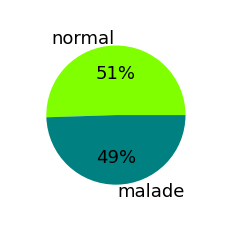


---------- histogramme ----------



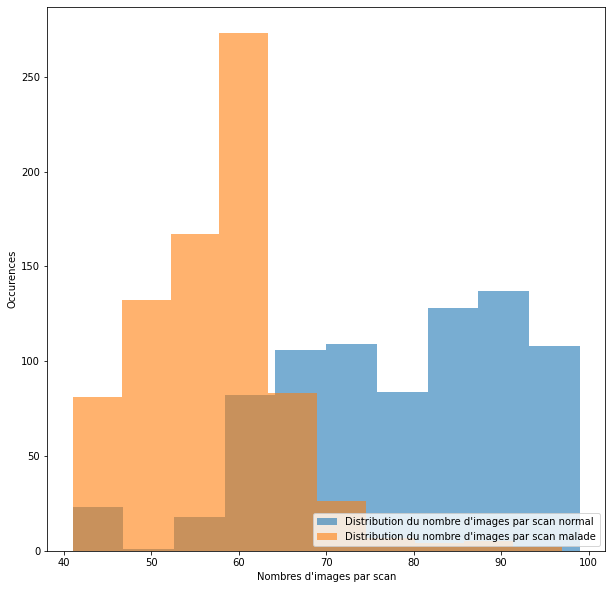


---------- infos sur les moyennes ----------

Moyenne d'images pour les scans cas "normal" : 78.14949748743719
Moyenne d'images pour les scans cas "malade" : 56.96923076923077
Moyenne d'images pour tous les scans confondus : 69.32410499200645


In [50]:
visualisation(True, True, True)

### II - 2. On comble les scans contenant moins de 70 images (Choix à faire)

#### II - 2.1. Méthode 1 : Comble par ajout d'images noires 

In [55]:
num_skipped = 0
from PIL import Image
for folder_name in ("normal", "malade"):
  folder_path = os.path.join("/tmp/COVID_crop", folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    if len(os.listdir(fpath)) < 70:
      for i in range (70 - len(os.listdir(fpath))) : 
        new_im = Image.new('RGB', (128, 128), (0, 0, 0))
        new_im.save(fpath + "/Dark_image" + str(i), "PNG")

In [ ]:
visualisation(True, False, True)

#### II - 2.2. Méthode 2 : Comble par copie d'images en partant du milieu du scan

In [7]:
from skimage.metrics import structural_similarity as compare_ssim
import argparse
import imutils
import cv2
import shutil
import os

def pathImg(index_img):
  if index_img < 10:
    return fpath + "/000" + str(index_img) + ".png"
  else:
    return fpath + "/00" + str(index_img) + ".png"

for folder_name in ("normal", "malade"):
  folder_path = os.path.join("/tmp/COVID_crop", folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    if len(os.listdir(fpath)) < 70:
      
      index_img1 = len(os.listdir(fpath))//2
      while os.path.exists(pathImg(index_img1)) == False:
        index_img1 += 1
      else:
        path_img1 = pathImg(index_img1)
        path_img2 = path_img1[:-6] + str(int(path_img1[len(path_img1)-6: -4]) + 2) + ".png"
        shutil.copy2(path_img1, path_img2)
        compteur_img_toAdd = 70 - len(os.listdir(fpath))
        #print(path_img2)
        #print(os.listdir(fpath))

        while compteur_img_toAdd != 0:
            
          index_img1 += 2
          path_img1 = pathImg(index_img1)
          path_img2 = path_img1[:-6] + str(int(path_img1[len(path_img1)-6: -4]) + 2) + ".png"
          shutil.copy2(path_img1, path_img2)
          compteur_img_toAdd -= 1

In [ ]:
visualisation(True, False, True)

### II - 3. On élimine des images dans les scans contenant plus de 70 images (Choix à faire)

#### II - 3.1. Méthode 1 : Elimination aléatoire

In [26]:
import shutil
import numpy as np

for folder_name in ("normal", "malade"):
    folder_path = os.path.join("/tmp/COVID_crop", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        if len(os.listdir(fpath)) > 70:
            while len(os.listdir(fpath)) !=70 :
                delete_path = fpath + "/00" + str(np.random.randint(10,len(os.listdir(fpath)))) + ".png"
                while os.path.exists(delete_path):  
                    os.remove(delete_path)


---------- infos générales ----------

Nombre de scans cas "normale" : 796
Nombre de scans cas "malade" : 780

Nombre d'images cas "normal" : 54248
Nombre d'images cas "malade" : 47236
Nombre d'images total : 101484


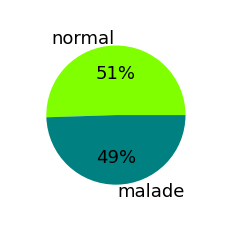


---------- histogramme ----------



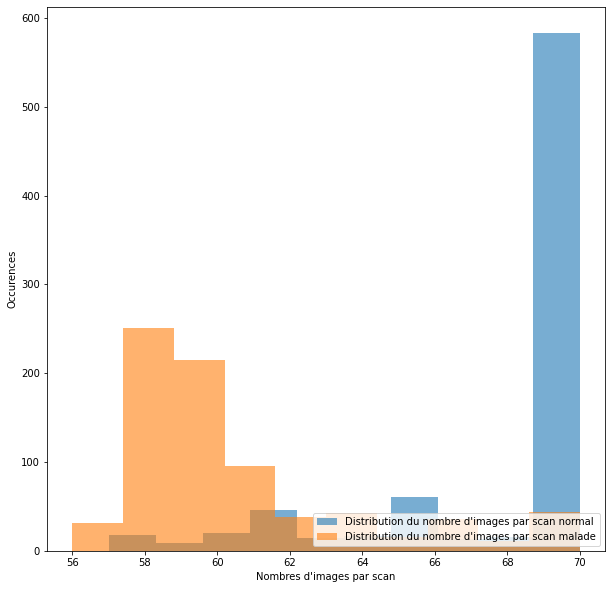


---------- infos sur les moyennes ----------

Moyenne d'images pour les scans cas "normal" : 68.15075376884423
Moyenne d'images pour les scans cas "malade" : 60.55897435897436
Moyenne d'images pour tous les scans confondus : 64.61713967987835


In [27]:
visualisation(True, True, True)

#### II - 3.2. Méthode 2 : Elimination par comparaison SSIM

##### II - 3.2. Test & explications

In [21]:
from skimage.metrics import structural_similarity as compare_ssim
import argparse
import imutils
import cv2
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from PIL import Image



path_image1 = "/tmp/COVID_crop/normal/1/0022.png"
path_image2 = "/tmp/COVID_crop/normal/1/0015.png"

# load the two input images
imageA = cv2.imread(path_image1)
imageB = cv2.imread(path_image2)

# compute the Structural Similarity Index (SSIM) between the two
# images, ensuring that the difference image is returned
(score, diff) = compare_ssim(imageA, imageB, full=True, multichannel=True)
diff = (diff * 255).astype("uint8")
print("SSIM(Score of similarity): {}".format(score))

from google.colab.patches import cv2_imshow
# show the output images
print("\nImage 1 :\n")

img = load_img(path_image1, target_size=(48,48))   
load_img.show()
print("\nImage 2 :\n")
cv2_imshow(imageB)
print("\nDifférence :\n")
cv2_imshow(diff)

SSIM(Score of similarity): 0.6683536764047817

Image 1 :



AttributeError: ignored

The ***score*** represents the structural similarity index between the two input images. This value can fall into the range [-1, 1] with a value of one being a “perfect match”.

The ***diff*** image contains the actual image differences between the two input images that we wish to visualize. The difference image is currently represented as a floating point data type in the range [0, 1] so we first convert the array to 8-bit unsigned integers in the range [0, 255] (Line 26) before we can further process it using OpenCV.

##### II - 3.2. Methode

In [12]:
from skimage.metrics import structural_similarity as compare_ssim
import argparse
import imutils
import cv2
import shutil
import numpy as np

def pathImg(index_img):
  if index_img < 10:
    return fpath + "/000" + str(index_img) + ".png"
  else:
    return fpath + "/00" + str(index_img) + ".png"

for folder_name in ("normal", "malade"):
  folder_path = os.path.join("/tmp/COVID_crop", folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    if len(os.listdir(fpath)) > 70:
      compteur_img_toDel = len(os.listdir(fpath)) - 70
      while compteur_img_toDel != 0:

        # ---------- choix des images à comparer ----------
        
        # choix index image1
        # sachant que les images sont numérotées entre 0001 et 0***
        # méthode : choix random de l'index
        
        index_img1 = np.random.randint(1, len(os.listdir(fpath)) - 1)
        while os.path.exists(pathImg(index_img1)) == False:
          index_img1 = np.random.randint(1, len(os.listdir(fpath)) - 1)
        else:
          path_img1 = pathImg(index_img1)

        # choix index image2
        # sachant qu'elle doit être la plus proche voisine de l'image1
        # méthode : recherche de l'index le plus proche supérieur
        
        index_img2 = index_img1 + 1                
        while os.path.exists(pathImg(index_img2)) == False:
          index_img2 += 1
        else:
          path_img2 = pathImg(index_img2)

        # ------------- comparaison des 2 images successives -------------
        
        image1 = cv2.imread(path_img1)
        image2 = cv2.imread(path_img2)
        #print("\nImage1\nPath : ", path_img1, "\nShape : ", image1.shape)
        #print("Image2\nPath : ", path_img2, "\nShape : ", image2.shape, "\n")
        (score, diff) = compare_ssim(image1, image2, full=True, multichannel=True)
        diff = (diff * 255).astype("uint8")
        #print(fpath, compteur_img_toDel, "SSIM: {}".format(score))

        # ---------- suppression de l'image1 ----------
        
        # critère : SSIM > 0.80 (images très similaires)
        if score > 0.80 and compteur_img_toDel != 0 :
          compteur_img_toDel -= 1
          while os.path.exists(path_img1):
            os.remove(path_img1)


---------- infos générales ----------

Nombre de scans cas "normale" : 796
Nombre de scans cas "malade" : 780

Nombre d'images cas "normal" : 54248
Nombre d'images cas "malade" : 47236
Nombre d'images total : 101484


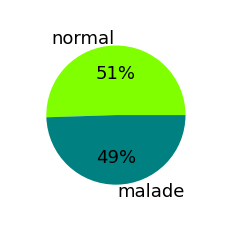


---------- infos sur les moyennes ----------

Moyenne d'images pour les scans cas "normal" : 68.15075376884423
Moyenne d'images pour les scans cas "malade" : 60.55897435897436
Moyenne d'images pour tous les scans confondus : 64.61713967987835


In [24]:
visualisation(True, False, True)

Attention méthode SSIM moyen car des images toutes noires sont plus similaires à d'autres "moyenne" que deux "moyennes" entre elles...

# **III - Conversion ...

*   Élément de liste
*   Élément de liste



In [ ]:
# faire un truc du type, en créant des fonctions pour chaque type de padding des données dans la partie précédente
'''padding(ecremageGrossier, remplissageScansMethode1, epurationScansMethode1)'''


---------- infos générales ----------

Nombre de scans cas "normale" : 796
Nombre de scans cas "malade" : 780

Nombre d'images cas "normal" : 54248
Nombre d'images cas "malade" : 47236
Nombre d'images total : 101484


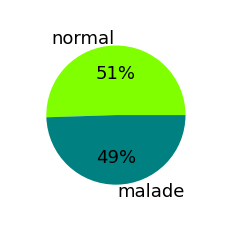


---------- histogramme ----------



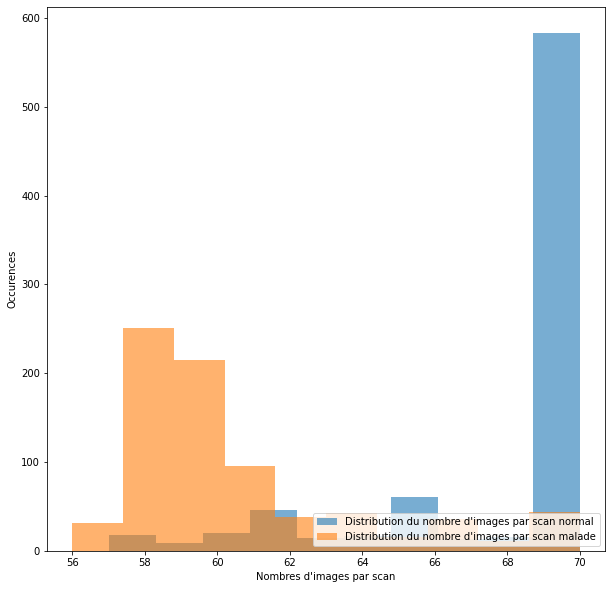


---------- infos sur les moyennes ----------

Moyenne d'images pour les scans cas "normal" : 68.15075376884423
Moyenne d'images pour les scans cas "malade" : 60.55897435897436
Moyenne d'images pour tous les scans confondus : 64.61713967987835


In [22]:
visualisation(True, True, True)

In [32]:
import os
import h5py
from keras.preprocessing.image import load_img, img_to_array, array_to_img
import PIL

arrlist_normal = []
folder_path = os.path.join("/tmp/COVID_crop", "normal")
for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    for imgs in os.listdir(fpath):
      array = np.array(Image.open(fpath +"/"+ imgs).resize((48,48)))/255
      arrlist_normal.append(array)          

arrlist_malade = []
folder_path = os.path.join("/tmp/COVID_crop", "malade")
for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    for imgs in os.listdir(fpath):
      array = np.array(Image.open(fpath +"/"+ imgs).resize((48,48)))/255
      arrlist_malade.append(array)  

In [31]:
arrlist = np.array(arrlist)
arrlist.shape

(54248, 48, 48, 3)

In [36]:
h5f = h5py.File('/content/drive/MyDrive/UV PROJET P6/Dataset_normal.hdf5', 'w')
h5f.create_dataset('dataset_1', data=arrlist_normal)
h5f.close()



In [37]:
h5f1 = h5py.File('/content/drive/MyDrive/UV PROJET P6/Dataset_malade.hdf5', 'w')
h5f1.create_dataset('dataset_2', data=arrlist_malade)
h5f1.close()

# **IV - Phase d'entrainement du modèle**



In [58]:
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras import backend as K
import numpy as np
import os
import math
import multiprocessing.pool


class VideoDirIterator(image.Iterator):
    def __init__(self,
                 directory,
                 video_data_generator,
                 target_size=(112,112),
                 batch_size=32,
                 clip_size=16,
                 shuffle=True,
                 allow_lt_clip_size=True,
                 seed=None,
                 data_format="channels_last",
                 save_to_dir=None,
                 save_prefix='',
                 save_format='png'):
        # TODO: parammeter explaination
        """
        directory:
        video_data_generator:
        target_size:
        batch_size:
        clip_size:
        shuffle:
        allow_lt_clip_size: whether allow the number of frames less than clip size
        seed:
        data_format: "channel_last": "NDHWC", "channel_first": "NCDHW".
        save_to_dir:
        save_prefix:
        save_format:
        """
        if data_format is None:
            data_format = K.image_data_format
        self.directory = directory
        self.video_data_generator = video_data_generator
        self.target_size = tuple(target_size)
        self.batch_size = batch_size
        self.clip_size = clip_size
        self.allow_lt_clip_size = allow_lt_clip_size
        self.data_format = data_format
        # set video shape
        if self.data_format == 'channels_last':
            self.video_shape = (self.clip_size,) + self.target_size + (3,)
        else:
            self.video_shape = (3,) + (self.clip_size,) + self.target_size
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format

        self.class_name = self._get_class_name()
        self.num_classes = len(self.class_name)
        self.class_indices = dict(zip(self.class_name, range(self.num_classes)))

        self.filenames, self.classes = self._get_filenames_and_classes()
        self.samples = len(self.filenames)

        print('Found %d videos belonging to %d classes.' % (self.samples, self.num_classes))

        super(VideoDirIterator, self).__init__(self.samples, batch_size, shuffle, seed)

    def _get_batches_of_transformed_samples(self, index_array):
        # "NDHWC": channel last
        # "NCDHW": channel first
        batch_shape = (len(index_array),) + self.video_shape
        batch_x = np.zeros(batch_shape, dtype=K.floatx())
        batch_y = np.zeros((len(batch_x), self.num_classes), dtype=K.floatx())

        for i, j in enumerate(index_array):
            # get filename, regard the filenames as video dir full path
            vfname = self.filenames[j]
            frame_list = os.listdir(vfname)
            # get list of frames, and choose clip_size of frames
            if self.allow_lt_clip_size and len(frame_list)<=self.clip_size:
                # repeat the frame list, if the length of list is less than clip size
                num = math.ceil(self.clip_size/len(frame_list))
                batch_list = num * frame_list
                batch_list = batch_list[0 : self.clip_size]
            else:
                index = np.random.randint(0, len(frame_list)-self.clip_size)
                batch_list = frame_list[index : index+self.clip_size]
            # transform
            # TODO: apply the same transformation to a clip or different transformation to each frame?
            # currently, I determin to apply the same transformation to a clip
            clip = []
            for frame in batch_list:
                img_path = os.path.join(vfname, frame)
                img = image.load_img(img_path, target_size=self.target_size)
                # convert image to array, set "channels_last" as the default data format
                # in the end convert the data format to users' configuraton
                x = image.img_to_array(img, data_format="channels_last")
                x = self.video_data_generator.random_transform(x)
                x = self.video_data_generator.standardize(x)
                clip.append(x)

            # generate batch_x
            clip = np.array(clip)
            if self.data_format == 'channels_first':
                clip = clip.transpose((3, 0, 1, 2))
            batch_x[i] = clip
            # generate batch_y
            labels = np.array(self.classes)
            for i, label in enumerate(labels[index_array]):
                batch_y[i, label] = 1

            # TODO: additional function

        return batch_x, batch_y

    def next(self):
        """For python 2.x.
        Returns:
            The next batch.
        """
        with self.lock:
            index_array = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        return self._get_batches_of_transformed_samples(index_array)

    def _get_class_name(self):
        # traverse root dir
        class_name = []
        for subdir in sorted(os.listdir(self.directory)):
            if os.path.isdir(os.path.join(self.directory, subdir)):
                class_name.append(subdir)
        return class_name

    def _get_filenames_and_classes(self):
        filenames = []
        results = []
        # classes = np.zeros((self.samples,), dtype='int32')
        classes = []
        i = 0
        pool = multiprocessing.pool.ThreadPool()

        for dirpath in (os.path.join(self.directory, subdir)
                        for subdir in self.class_name):
            results.append(
                pool.apply_async(self._list_video_samples, (dirpath,))
            )

        for res in results:
            filename, cls = res.get()
            # classes[i:i+len(cls)] = cls
            classes = classes + cls
            filenames += filename
            i += len(cls)

        pool.close()
        pool.join()
        return filenames, classes

    def _list_video_samples(self, base_path):
        filenames = []
        classes = []
        dir_name = os.path.basename(base_path)

        for subdir in sorted(os.listdir(base_path)):
            filename = os.path.join(base_path, subdir)
            if not os.path.isdir(filename):
                continue
            if self.allow_lt_clip_size:
                filenames.append(filename)
                classes.append(self.class_indices[dir_name])
            else:
                if self._list_frame(filename):
                    filenames.append(filename)
                    classes.append(self.class_indices[dir_name])

        return filenames, classes

    def _list_frame(self, base_path):
        if len(os.listdir(base_path)) < self.clip_size:
            return False
        else:
            return True


class VideoDataGenerator(image.ImageDataGenerator):
    def __init__(self,
                 featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 zca_epsilon=1e-6,
                 rotation_range=0.,
                 width_shift_range=0.,
                 height_shift_range=0.,
                 brightness_range=None,
                 shear_range=0.,
                 zoom_range=0.,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=False,
                 vertical_flip=False,
                 rescale=None,
                 preprocessing_function=None,
                 data_format="channels_last",
                 validation_split=0.0):
        super(VideoDataGenerator, self).__init__(
                 featurewise_center=featurewise_center,
                 samplewise_center=samplewise_center,
                 featurewise_std_normalization=featurewise_std_normalization,
                 samplewise_std_normalization=samplewise_std_normalization,
                 zca_whitening=zca_whitening,
                 zca_epsilon=zca_epsilon,
                 rotation_range=rotation_range,
                 width_shift_range=width_shift_range,
                 height_shift_range=height_shift_range,
                 brightness_range=brightness_range,
                 shear_range=shear_range,
                 zoom_range=zoom_range,
                 channel_shift_range=channel_shift_range,
                 fill_mode=fill_mode,
                 cval=cval,
                 horizontal_flip=horizontal_flip,
                 vertical_flip=vertical_flip,
                 rescale=rescale,
                 preprocessing_function=preprocessing_function,
                 data_format=data_format,
                 validation_split=validation_split)

    def flow_from_directory(self,
                            directory,
                            target_size=(112, 112),
                            batch_size=32,
                            clip_size=16,
                            allow_lt_clip_size=True,
                            shuffle=True,
                            seed=None,
                            save_to_dir=None,
                            save_prefix='',
                            save_format='png',
                            ):
        return VideoDirIterator(
            directory,
            self,
            target_size=target_size,
            batch_size=batch_size,
            clip_size=clip_size,
            allow_lt_clip_size=allow_lt_clip_size,
            shuffle=shuffle,
            seed=None,
            data_format=self.data_format,
            save_to_dir=None,
            save_prefix='',
            save_format='png')

In [60]:

import shutil
import numpy as np


source1 = "/tmp/COVID_crop/malade"
dest11 = "/tmp/datasett/test/malade"
files = os.listdir("/tmp/COVID_crop/malade")

for f in files:
    if np.random.rand(1) < 0.2:
        shutil.move(source1 + '/'+ f, dest11 + '/'+ f)

source1 = "/tmp/COVID_crop/malade"
dest11 = "/tmp/datasett/train/malade"
files = os.listdir("/tmp/COVID_crop/malade")

for f in files:
    if np.random.rand(1) < 0.8:
        shutil.move(source1 + '/'+ f, dest11 + '/'+ f)
source1 = "/tmp/COVID_crop/malade"
dest11 = "/tmp/datasett/validation/malade"
files = os.listdir("/tmp/COVID_crop/malade")

for f in files:
   shutil.move(source1 + '/'+ f, dest11 + '/'+ f)
source1 = "/tmp/COVID_crop/normal"
dest11 = "/tmp/datasett/test/normal"
files = os.listdir("/tmp/COVID_crop/normal")

for f in files:
    if np.random.rand(1) < 0.2:
        shutil.move(source1 + '/'+ f, dest11 + '/'+ f)



source1 = "/tmp/COVID_crop/normal"
dest11 = "/tmp/datasett/train/normal"
files = os.listdir("/tmp/COVID_crop/normal")

for f in files:
    if np.random.rand(1) < 0.8:
        shutil.move(source1 + '/'+ f, dest11 + '/'+ f)




source1 = "/tmp/COVID_crop/normal"
dest11 = "/tmp/datasett/validation/normal"
files = os.listdir("/tmp/COVID_crop/normal")

for f in files:
    shutil.move(source1 + '/'+ f, dest11 + '/'+ f)







gen = VideoDataGenerator(rescale = 1./255)
training_set = gen.flow_from_directory(
        directory="/tmp/datasett/train",
        target_size=(128,128),
        shuffle=True
    )
test_set = gen.flow_from_directory(
        directory="/tmp/datasett/test",
        target_size=(128,128),
        shuffle=True
    )
validation_set = gen.flow_from_directory(
        directory="/tmp/datasett/validation",
        target_size=(128,128),
        shuffle=True
    )

Found 1001 videos belonging to 2 classes.
Found 345 videos belonging to 2 classes.
Found 230 videos belonging to 2 classes.


In [73]:
len(os.listdir("/tmp/datasett/test/normal/178"))

70

In [77]:
training_set.class_name
training_set.video_shape



(16, 128, 128, 3)

In [74]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN

model = Sequential()
model.add(LSTM((16), activation='relu', input_shape=(16,128,128,3)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')


ValueError: ignored

In [30]:
history = model.fit(training_set, epochs=10)


Epoch 1/10


ValueError: ignored